In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


from sklearn.model_selection import GridSearchCV
import yfinance as yf

from datetime import datetime, timedelta

import requests
import json

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
import yfinance as yf
from datetime import datetime, timedelta
import datetime



end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

tesla_data = yf.download('TSLA', start=start_date, end=end_date)
apple_data = yf.download('AAPL', start=start_date, end=end_date)
amazon_data = yf.download('AMZN', start=start_date, end=end_date)


#GOLD Data

gold_data = yf.download('GC=F', start=start_date, end=end_date)


#ETF's

api_key = '2YW9PTCOWXKLLTNS'


qqq_symbol = 'QQQ'
spdr_symbol = 'SPY'
ishr_symbol = 'IWM'

output_format = 'json'

base_url = 'https://www.alphavantage.co/query'

def fetch_etf_data(api_key, symbol, output_format, start_date, end_date):
    # Define the API parameters
    params = {
        'function': 'TIME_SERIES_DAILY',  # Daily time series data
        'symbol': symbol,
        'outputsize': 'full',  # Retrieve full historical data
        'datatype': output_format,
        'apikey': api_key,
        'start_date': start_date,  # Specify the start date
        'end_date': end_date      # Specify the end date
    }

    try:

        response = requests.get(base_url, params=params)
        data = response.json() if output_format == 'json' else response.text

        # Check for API request success
        if 'Time Series (Daily)' in data:
            return data['Time Series (Daily)']
        else:
            print("API request was not successful. Check your API key or symbol.")
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


invesco_data = pd.DataFrame(fetch_etf_data(api_key, qqq_symbol, output_format, start_date, end_date))
ishares_data = pd.DataFrame(fetch_etf_data(api_key, ishr_symbol, output_format, start_date, end_date))
spdr_data = pd.DataFrame(fetch_etf_data(api_key, spdr_symbol, output_format, start_date, end_date))

spdr_data = spdr_data.T
ishares_data = ishares_data.T
invesco_data = invesco_data.T


#bitcoin

api_key = "5DyC56vN-RWdz61xD4-m"
url = f"https://www.quandl.com/api/v3/datasets/BCHAIN/MKPRU/data.json?start_date={start_date}&end_date={end_date}&api_key={api_key}"
response = requests.get(url)
bitcon_data = response.json()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [33]:

test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [34]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean()
    std_list = df[col].rolling(window = N, min_periods=1).std()

    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list

    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """

    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std

    row_scaled = (row-feat_mean) / feat_std

    return row_scaled

def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100




In [35]:
df = tesla_data

In [36]:
df.head()

df['date']=df.index

df=df.reset_index(drop=True)


# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,open,high,low,close,adj_close,volume,date,month
0,11.666667,12.166667,11.610000,11.981333,11.981333,116544000,2013-10-14,10
1,12.352000,12.586000,12.212000,12.262667,12.262667,164677500,2013-10-15,10
2,12.326667,12.486667,12.139333,12.237333,12.237333,123081000,2013-10-16,10
3,12.236000,12.320000,12.066000,12.186667,12.186667,100575000,2013-10-17,10
4,12.276667,12.397333,12.168000,12.226667,12.226667,88962000,2013-10-18,10


In [37]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,adj_close,volume,date,month,range_hl,range_oc
0,11.981333,116544000,2013-10-14,10,0.556667,-0.314666
1,12.262667,164677500,2013-10-15,10,0.374001,0.089334
2,12.237333,123081000,2013-10-16,10,0.347334,0.089334
3,12.186667,100575000,2013-10-17,10,0.254000,0.049333
4,12.226667,88962000,2013-10-18,10,0.229333,0.049999


In [38]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]
print(df.head())

# merging_keys
merging_keys = ['order_day']



   adj_close     volume       date  month  range_hl  range_oc  order_day
0  11.981333  116544000 2013-10-14     10  0.556667 -0.314666          0
1  12.262667  164677500 2013-10-15     10  0.374001  0.089334          1
2  12.237333  123081000 2013-10-16     10  0.347334  0.089334          2
3  12.186667  100575000 2013-10-17     10  0.254000  0.049333          3
4  12.226667   88962000 2013-10-18     10  0.229333  0.049999          4


['adj_Close', 'range_hl', 'range_oc', 'volume']

In [40]:
# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [ ]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()

    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)





print(train_shift.head())

del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]

df.head()

In [42]:
# # Get mean of adj_close of each month
df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
df_gb

# # Merge to main df
df = df.merge(df_gb,
               left_on=['month'],
            right_on=['month'],
               how='left').fillna(0)
df.head()


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean
0,12.186667,100575000,2013-10-17,10,0.254000,0.049333,3,12.237333,0.347334,0.089334,123081000.0,12.262667,0.374001,0.089334,164677500.0,11.981333,0.556667,-0.314666,116544000.0,83.586363
1,12.226667,88962000,2013-10-18,10,0.229333,0.049999,4,12.186667,0.254000,0.049333,100575000.0,12.237333,0.347334,0.089334,123081000.0,12.262667,0.374001,0.089334,164677500.0,83.586363
2,11.506667,172981500,2013-10-21,10,0.826000,0.712000,5,12.226667,0.229333,0.049999,88962000.0,12.186667,0.254000,0.049333,100575000.0,12.237333,0.347334,0.089334,123081000.0,83.586363
3,11.436000,170800500,2013-10-22,10,0.778000,-0.069333,6,11.506667,0.826000,0.712000,172981500.0,12.226667,0.229333,0.049999,88962000.0,12.186667,0.254000,0.049333,100575000.0,83.586363
4,10.966667,199806000,2013-10-23,10,0.777333,0.294000,7,11.436000,0.778000,-0.069333,170800500.0,11.506667,0.826000,0.712000,172981500.0,12.226667,0.229333,0.049999,88962000.0,83.586363


In [43]:
# # Get mean of volume of eaxh month
df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
df_gb = df_gb.rename(columns={'volume':'volume_mean'})
df_gb

# # Merge to main df
df = df.merge(df_gb,
              left_on=['month'],
               right_on=['month'],
               how='left').fillna(0)

df.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean
0,12.186667,100575000,2013-10-17,10,0.254000,0.049333,3,12.237333,0.347334,0.089334,...,12.262667,0.374001,0.089334,164677500.0,11.981333,0.556667,-0.314666,116544000.0,83.586363,1.063129e+08
1,12.226667,88962000,2013-10-18,10,0.229333,0.049999,4,12.186667,0.254000,0.049333,...,12.237333,0.347334,0.089334,123081000.0,12.262667,0.374001,0.089334,164677500.0,83.586363,1.063129e+08
2,11.506667,172981500,2013-10-21,10,0.826000,0.712000,5,12.226667,0.229333,0.049999,...,12.186667,0.254000,0.049333,100575000.0,12.237333,0.347334,0.089334,123081000.0,83.586363,1.063129e+08
3,11.436000,170800500,2013-10-22,10,0.778000,-0.069333,6,11.506667,0.826000,0.712000,...,12.226667,0.229333,0.049999,88962000.0,12.186667,0.254000,0.049333,100575000.0,83.586363,1.063129e+08
4,10.966667,199806000,2013-10-23,10,0.777333,0.294000,7,11.436000,0.778000,-0.069333,...,11.506667,0.826000,0.712000,172981500.0,12.226667,0.229333,0.049999,88962000.0,83.586363,1.063129e+08


In [44]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()
df.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

In [ ]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

In [ ]:
# Do scaling for dev set
cv_scaled = cv[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

# Now the entire dev set is scaled
cv_scaled.head()

In [ ]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

In [ ]:
# Do scaling for test set
test_scaled = test[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

# Now the entire test set is scaled
test_scaled.head()

In [54]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"
print(features)


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]


['adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'volume_lag_3']
X_train.shape = (1507, 12)
y_train.shape = (1507,)
X_cv.shape = (502, 12)
y_cv.shape = (502,)
X_train_cv.shape = (2009, 12)
y_train_cv.shape = (2009,)
X_sample.shape = (502, 12)
y_sample.shape = (502,)


In [55]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['adj_close']
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled['adj_close']
X_sample_scaled = test_scaled[features]


X_train_scaled.shape = (1507, 12)
y_train_scaled.shape = (1507,)
X_cv_scaled.shape = (502, 12)
X_train_cv_scaled.shape = (2009, 12)
y_train_cv_scaled.shape = (2009,)
X_sample_scaled.shape = (502, 12)


In [56]:
from sklearn.svm import SVR

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
clf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

In [60]:
clf.fit(X_train_scaled, y_train_scaled)

SVR(C=100, gamma=0.1)

In [64]:
forecast_set = clf.predict(X_sample_scaled)

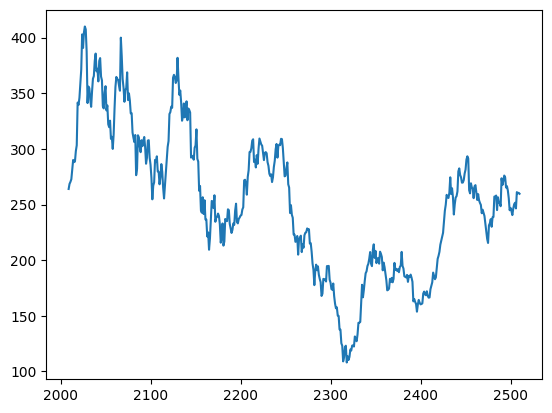

In [66]:
plt.plot(y_sample)

In [68]:
forecast_se = forecast_set*test['adj_close_std'] + test['adj_close_mean']

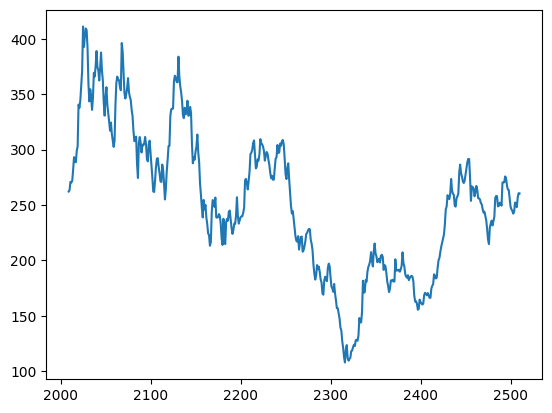

In [69]:
plt.plot(forecast_se)

In [71]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(forecast_se, y_sample)

7.822345819417926

[*********************100%%**********************]  1 of 1 completed
R2 score: 13.944525869988764


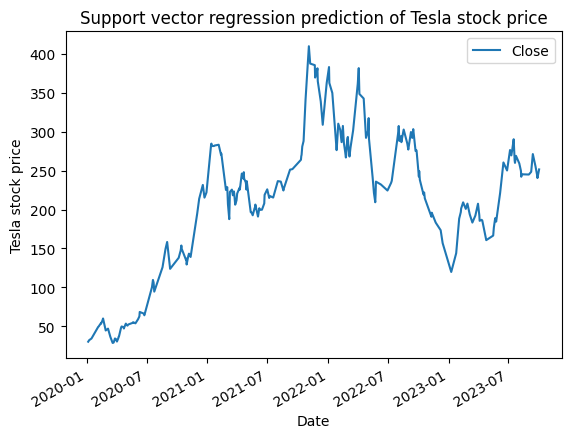

In [ ]:
import yfinance as yf
import matplotlib.pyplot as pl sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Download Tesla stock price data from yfinance
ticker = "TSLA"
start_date = "2020-01-01"
end_date = "2023-10-04"
data = yf.download(ticker, start_date, end_date)

# Prepare the data for modeling
# Select the "close" price as the target variable
target = data["close"]

# Select features for the model
features = data.drop(columns=["open", "high", "low", "Volume"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Create and train the support vector regression model
svr = SVR()
svr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test)

# Evaluate the model's accuracy
r2 = mean_absolute_error(y_test, y_pred)

# Print the model's accuracy
print("R2 score:", r2)
y_test.plot()

plt.legend()
plt.xlabel("Date")
plt.ylabel("Tesla stock price")
plt.title("Support vector regression prediction of Tesla stock price")
plt.show()


RANDOM FOREST REGRESSOR


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [73]:
rfr = RandomForestRegressor()
scaler = MinMaxScaler()

In [75]:
rfr.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor()

In [77]:
pred = rfr.predict(X_sample_scaled)

In [78]:
pred = pred*test['adj_close_std'] + test['adj_close_mean']

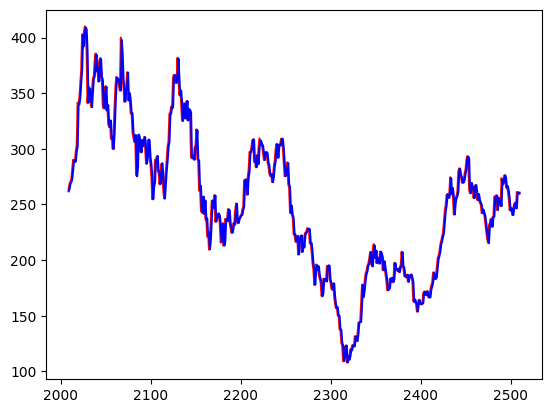

In [81]:
plt.plot(y_sample, color='r')
plt.plot(pred, color='b')

In [82]:
mean_absolute_error(y_sample, pred)


7.49175479672255